# Redes Neuronales - Energy efficiency-Regresión

In [1]:
!pip install scikeras[tensorflow] 
!pip install keras-metrics

  Using cached keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder #get_dummies
import seaborn as sns 
from sklearn.compose import ColumnTransformer

# Importo el dataset

In [3]:
df = pd.read_excel('ENB2012_data.xlsx')
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


**Modificar el nombre de las columnas del DF para mejoraar el análisis**

X1 Relative Compactness

X2 Surface Area

X3 Wall Area

X4 Roof Area

X5 Overall Height

X6 Orientation

X7 Glazing Area

X8 Glazing Area Distribution

y1 Heating Load

y2 Cooling Load

In [4]:
df.rename({'X1': 'Relative Compactness', 
           'X2': 'Surface Area', 
           'X3': 'Wall Area', 
           'X4': 'Roof Area',
           'X5': 'Overall Height', 
           'X6': 'Orientation',
           'X7': 'Glazing Area', 
           'X8': 'Glazing Area Distribution',
           'Y1': 'Y1-HL',
           'Y2': 'Y2-CL'}, axis=1, inplace = True)

### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing Area               768 non-null    float64
 7   Glazing Area Distribution  768 non-null    int64  
 8   Y1-HL                      768 non-null    float64
 9   Y2-CL                      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [9]:
df.columns

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Y1-HL', 'Y2-CL'],
      dtype='object')

In [10]:
df.shape # tamaño del df filas x columnas

(768, 10)

In [11]:
df.describe().T.style.set_properties(**{'background-color': 'grey','color': 'white','border-color': 'white'}) # estadisticos basicos

,count,mean,std,min,25%,50%,75%,max
Relative Compactness,768.000000,0.764167,0.105777,0.620000,0.682500,0.750000,0.830000,0.980000
Surface Area,768.000000,671.708333,88.086116,514.500000,606.375000,673.750000,741.125000,808.500000
Wall Area,768.000000,318.500000,43.626481,245.000000,294.000000,318.500000,343.000000,416.500000
Roof Area,768.000000,176.604167,45.165950,110.250000,140.875000,183.750000,220.500000,220.500000
Overall Height,768.000000,5.250000,1.751140,3.500000,3.500000,5.250000,7.000000,7.000000
Orientation,768.000000,3.500000,1.118763,2.000000,2.750000,3.500000,4.250000,5.000000
Glazing Area,768.000000,0.234375,0.133221,0.000000,0.100000,0.250000,0.400000,0.400000
Glazing Area Distribution,768.000000,2.812500,1.550960,0.000000,1.750000,3.000000,4.000000,5.000000
Y1-HL,768.000000,22.307195,10.090204,6.010000,12.992500,18.950000,31.667500,43.100000
Y2-CL,768.000000,24.587760,9.513306,10.900000,15.620000,22.080000,33.132500,48.030000


In [12]:
df.duplicated().sum() # visualizo si hay fila duplicadas

0

In [14]:
df.isna().sum() # visualizo si hay nulos

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Y1-HL                        0
Y2-CL                        0
dtype: int64

In [15]:
df.dtypes.value_counts() #visualizo los tipos de datos

float64    8
int64      2
dtype: int64

In [16]:
# visualizo los valores únicos
for i in list(df.columns):
    
    # get a list of unique values
    
    n = df[i].unique()
    print(i)
    print(n)
    #print('\n')
   

Relative Compactness
[0.98 0.9  0.86 0.82 0.79 0.76 0.74 0.71 0.69 0.66 0.64 0.62]
Surface Area
[514.5 563.5 588.  612.5 637.  661.5 686.  710.5 735.  759.5 784.  808.5]
Wall Area
[294.  318.5 343.  416.5 245.  269.5 367.5]
Roof Area
[110.25 122.5  147.   220.5 ]
Overall Height
[7.  3.5]
Orientation
[2 3 4 5]
Glazing Area
[0.   0.1  0.25 0.4 ]
Glazing Area Distribution
[0 1 2 3 4 5]
Y1-HL
[15.55  20.84  21.46  20.71  19.68  19.5   19.95  19.34  18.31  17.05
 17.41  16.95  15.98  28.52  29.9   29.63  28.75  24.77  23.93   6.07
  6.05   6.01   6.04   6.37   6.4    6.366  6.85   6.79   6.77   6.81
  7.18   7.1   10.85  10.54  10.77  10.56   8.6    8.49   8.45   8.5
 24.58  24.63  24.59  29.03  29.87  29.14  28.09  26.28  26.91  26.37
 25.27  23.53  24.03  23.54  22.58  35.56  37.12  36.9   35.94  32.96
 32.12  32.94  32.21  10.36  10.43  10.39  10.71  10.8   10.7   10.75
 11.11  11.13  11.09  11.16  11.68  11.69  11.7   15.41  15.2   15.42
 15.21  12.96  12.97  12.93  13.02  24.29  24.31 

## Target 1: Y1-HL y Target 2: Y2-CL
Cuanta con 2 variables target de variable continuas

In [20]:
df['Y1-HL'].value_counts() 

15.16    6
13.00    5
15.23    4
28.15    4
14.60    4
        ..
33.21    1
36.77    1
36.71    1
37.03    1
16.64    1
Name: Y1-HL, Length: 587, dtype: int64

In [21]:
df['Y2-CL'].value_counts()

21.33    4
29.79    4
14.27    4
17.20    4
14.28    4
        ..
14.65    1
14.54    1
14.39    1
14.46    1
17.11    1
Name: Y2-CL, Length: 636, dtype: int64

<AxesSubplot:xlabel='Y1-HL', ylabel='Count'>

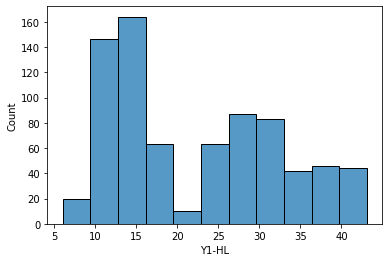

In [22]:
sns.histplot(data=df, x='Y1-HL') # distribución de variables cuantitativas

<AxesSubplot:xlabel='Y2-CL', ylabel='Count'>

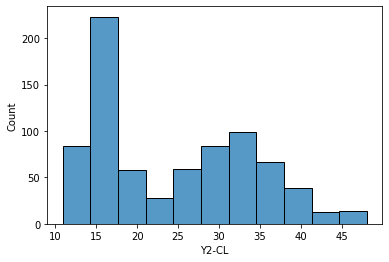

In [23]:
sns.histplot(data=df, x='Y2-CL')

## Análisis de variables
### Comparción de las variables con las variables targets

In [24]:
df['Relative Compactness'].value_counts()

0.98    64
0.90    64
0.86    64
0.82    64
0.79    64
0.76    64
0.74    64
0.71    64
0.69    64
0.66    64
0.64    64
0.62    64
Name: Relative Compactness, dtype: int64

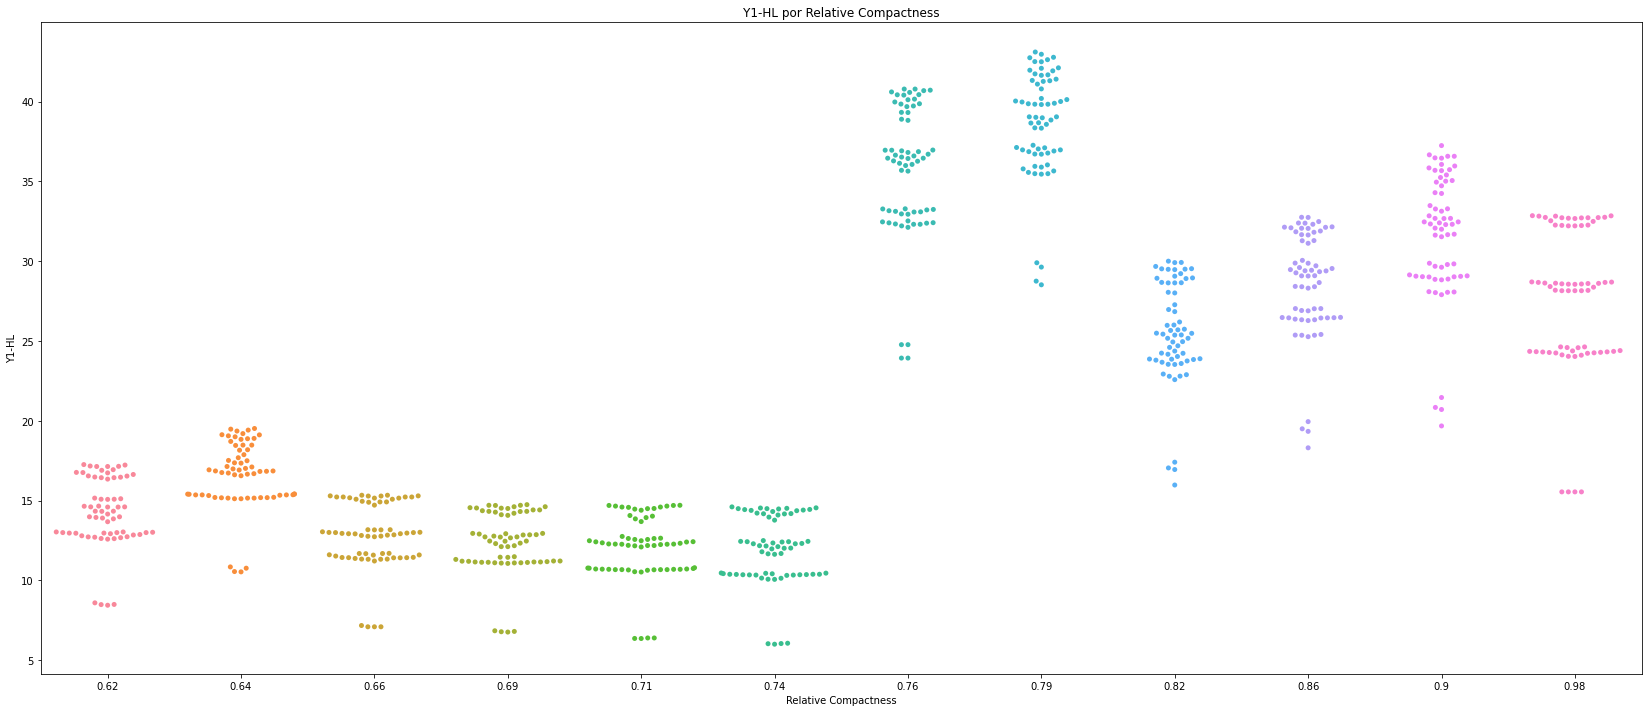

In [25]:
plt.figure(figsize=(23,10))
sns.swarmplot(x='Relative Compactness', y='Y1-HL', data=df).set_title('Y1-HL por Relative Compactness')
plt.tight_layout()
plt.show()

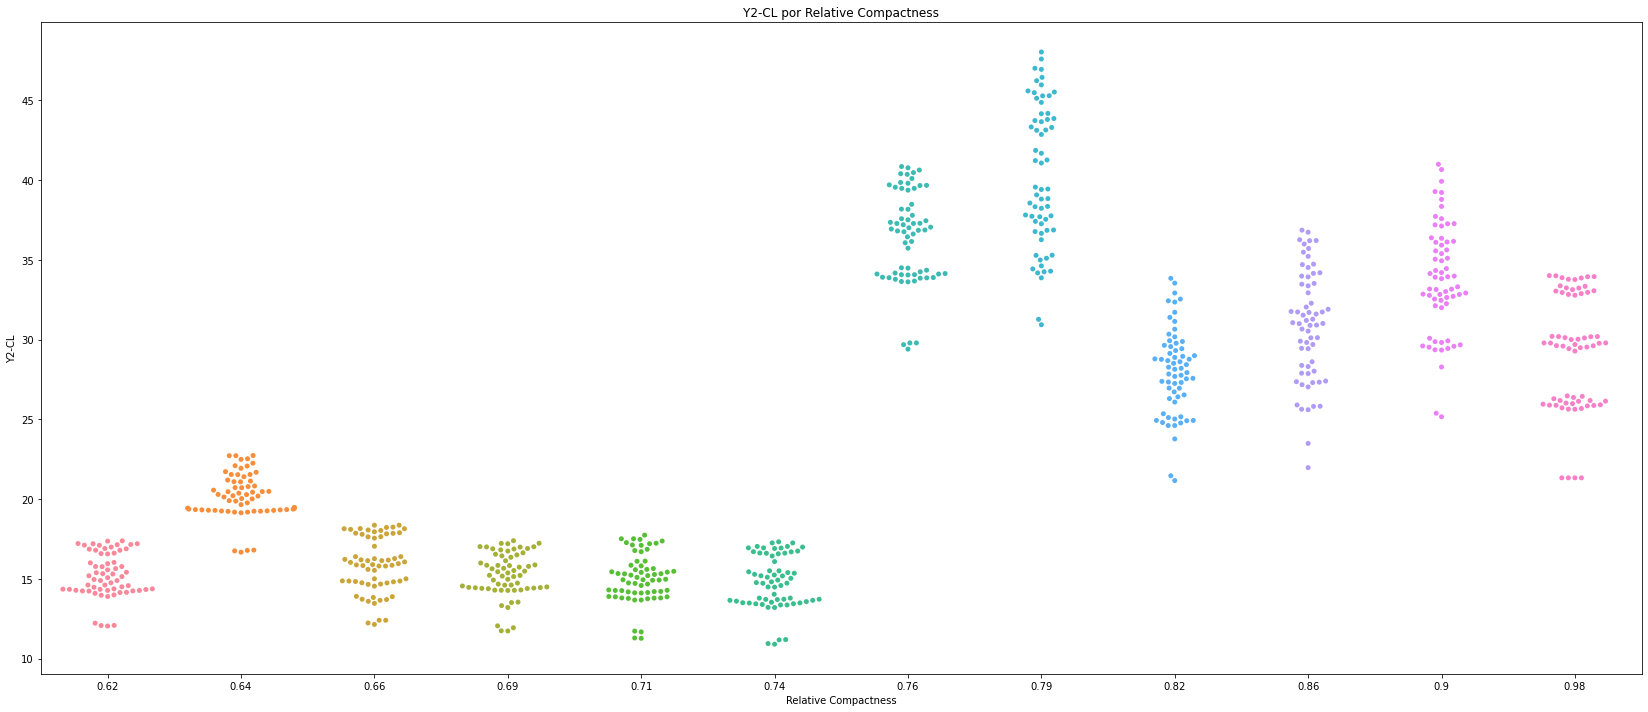

In [26]:
plt.figure(figsize=(23,10))
sns.swarmplot(x='Relative Compactness', y='Y2-CL', data=df).set_title('Y2-CL por Relative Compactness')
plt.tight_layout()
plt.show()

<AxesSubplot:>

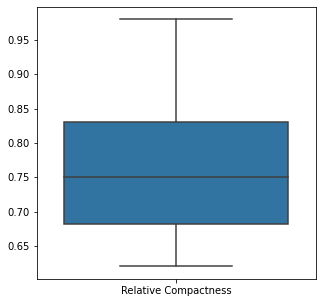

In [27]:
plt.figure(figsize = (5, 5)) # no tiene outliers
sns.boxplot( data = df[['Relative Compactness']])

In [28]:
df['Surface Area'].value_counts()

514.5    64
563.5    64
588.0    64
612.5    64
637.0    64
661.5    64
686.0    64
710.5    64
735.0    64
759.5    64
784.0    64
808.5    64
Name: Surface Area, dtype: int64

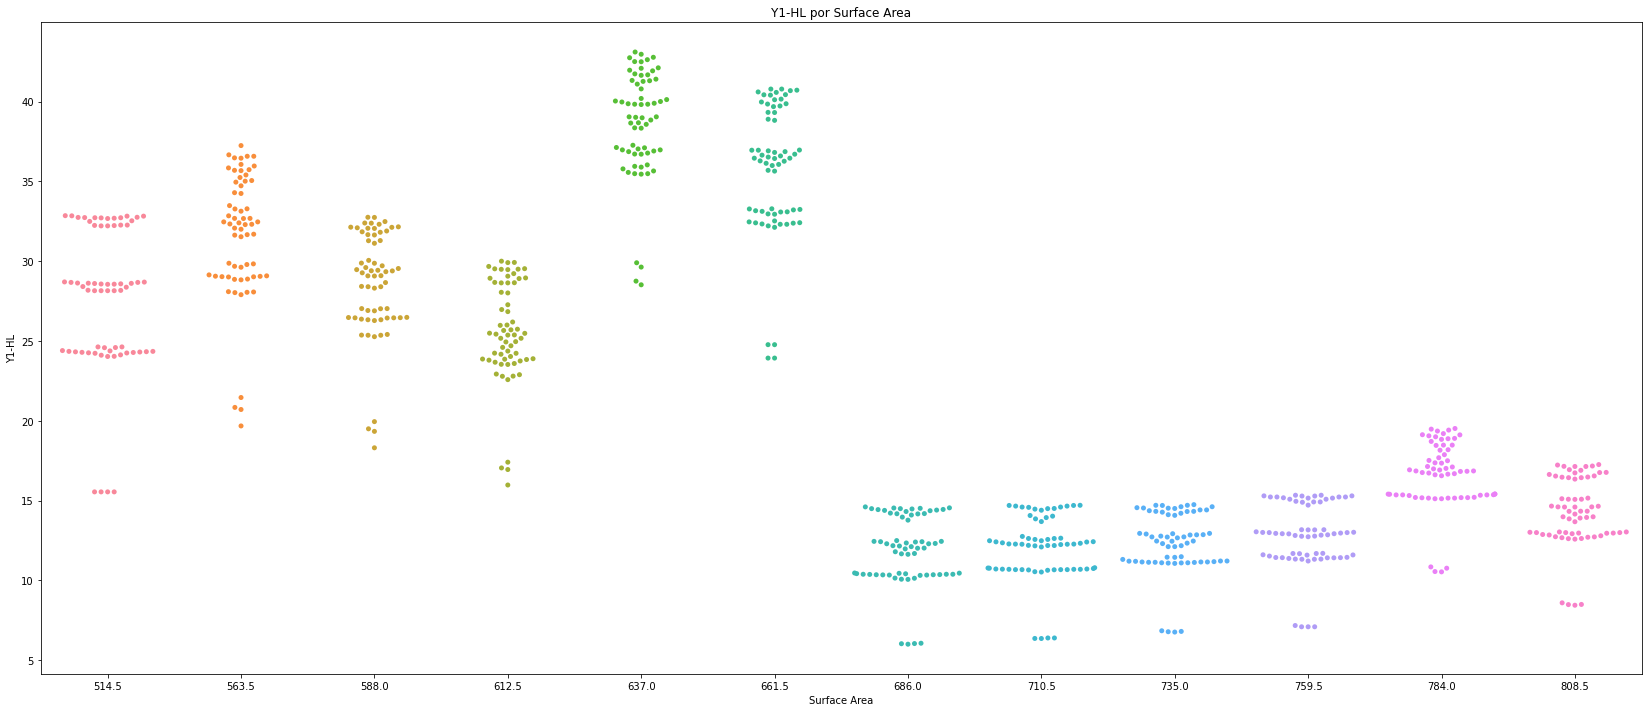

In [29]:


plt.figure(figsize=(23,10))
sns.swarmplot(x='Surface Area', y='Y1-HL', data=df).set_title('Y1-HL por Surface Area')
plt.tight_layout()
plt.show()


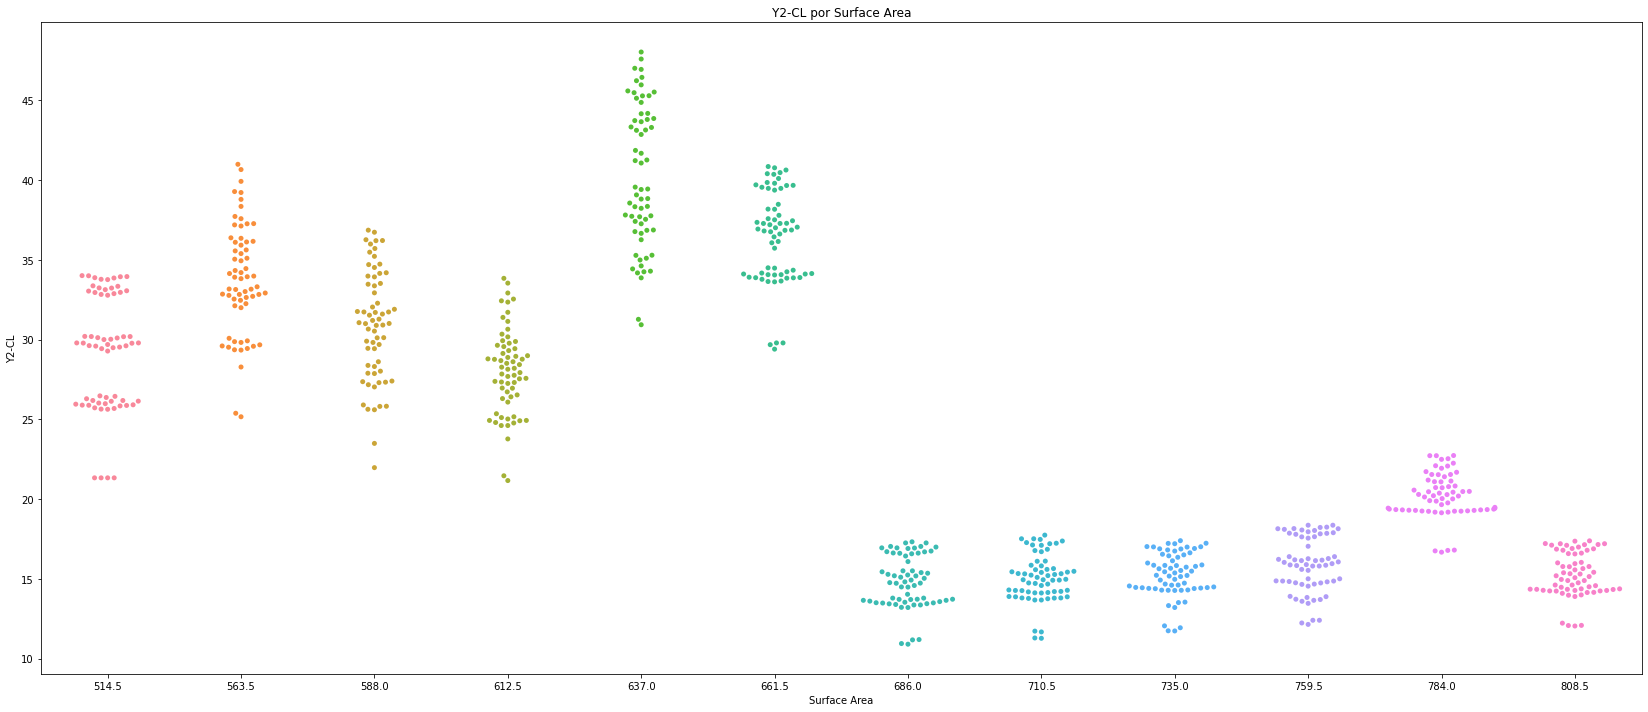

In [30]:

plt.figure(figsize=(23,10))
sns.swarmplot(x='Surface Area', y='Y2-CL', data=df).set_title('Y2-CL por Surface Area')
plt.tight_layout()
plt.show()

<AxesSubplot:>

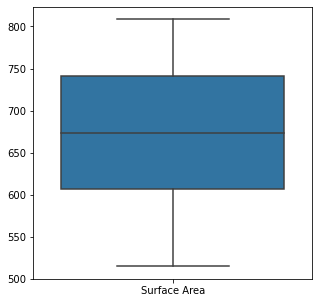

In [31]:
plt.figure(figsize = (5, 5))
sns.boxplot( data = df[['Surface Area']])

In [32]:
df['Wall Area'].value_counts()

294.0    192
318.5    192
343.0    128
416.5     64
245.0     64
269.5     64
367.5     64
Name: Wall Area, dtype: int64

C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


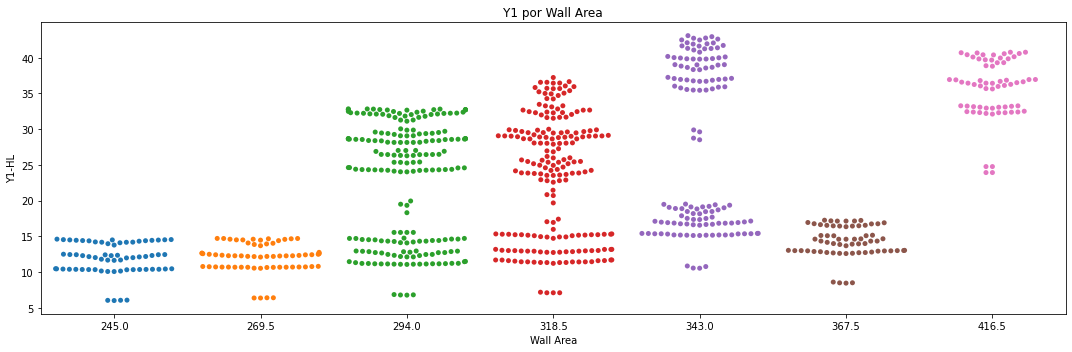

In [33]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Wall Area', y='Y1-HL', data=df).set_title('Y1 por Wall Area')
plt.tight_layout()
plt.show()

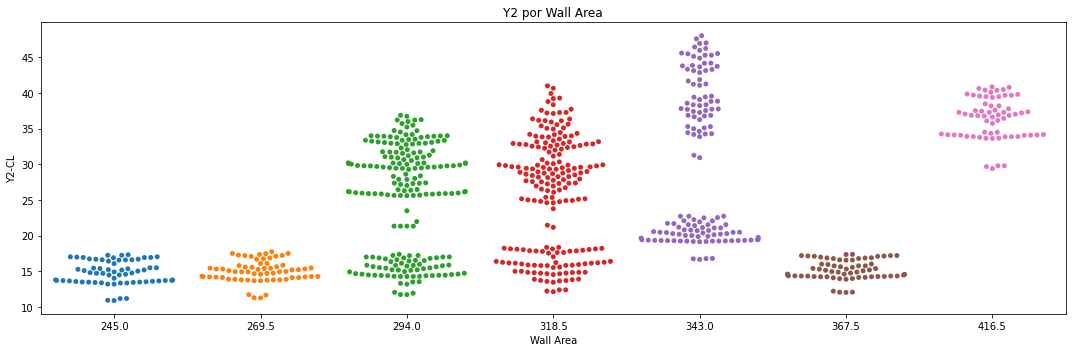

In [34]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Wall Area', y='Y2-CL', data=df).set_title('Y2 por Wall Area')
plt.tight_layout()
plt.show()

<AxesSubplot:>

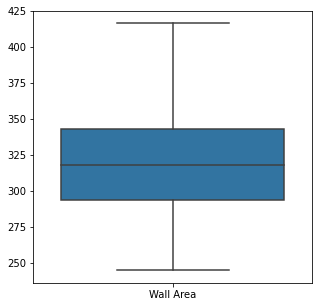

In [35]:
plt.figure(figsize = (5, 5))
sns.boxplot( data = df[['Wall Area']])

In [36]:
df['Roof Area'].value_counts() 

220.50    384
147.00    192
122.50    128
110.25     64
Name: Roof Area, dtype: int64

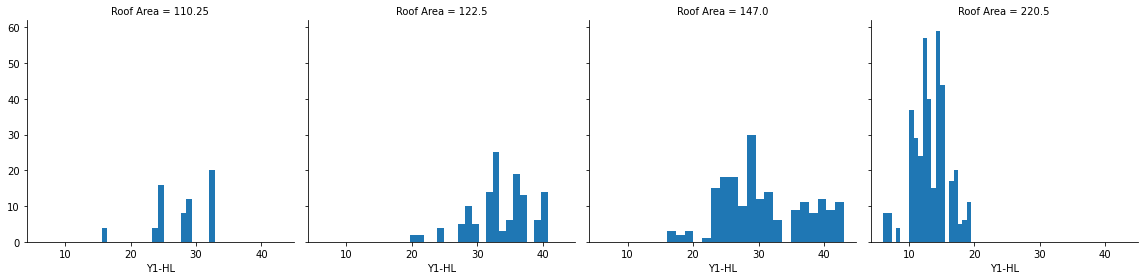

In [37]:
g = sns.FacetGrid(df, col='Roof Area', height=4, sharey= True)
g.map(plt.hist, 'Y1-HL', bins=20)


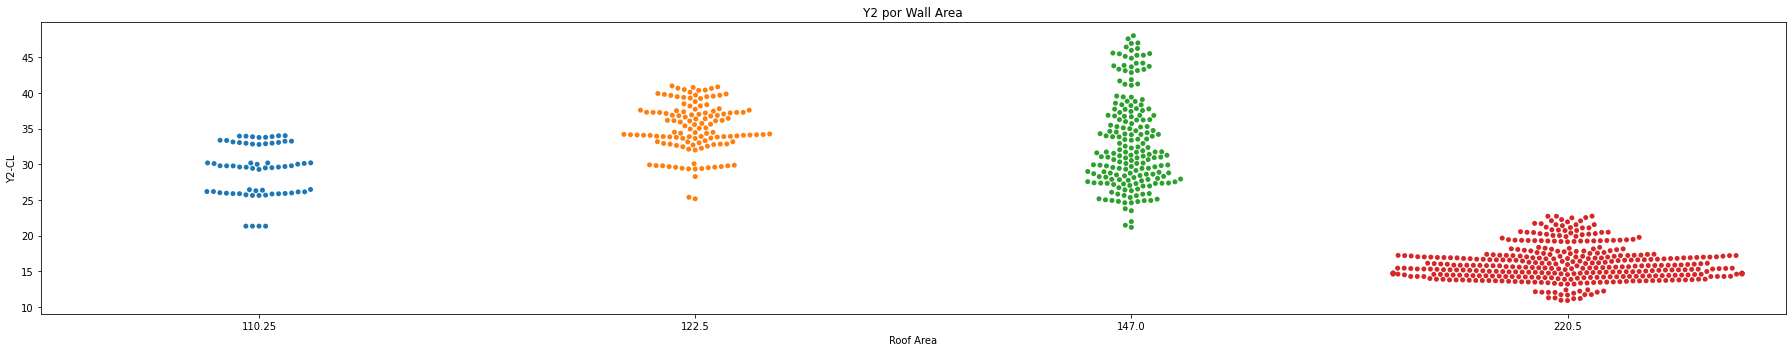

In [38]:
plt.figure(figsize=(25,5))
sns.swarmplot(x='Roof Area', y='Y2-CL', data=df).set_title('Y2 por Wall Area')
plt.tight_layout()
plt.show()

<AxesSubplot:>

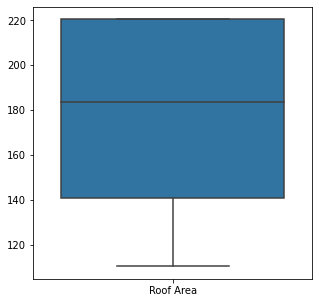

In [39]:
plt.figure(figsize = (5, 5))
sns.boxplot( data = df[['Roof Area']])

In [40]:
df['Overall Height'].value_counts() 

7.0    384
3.5    384
Name: Overall Height, dtype: int64

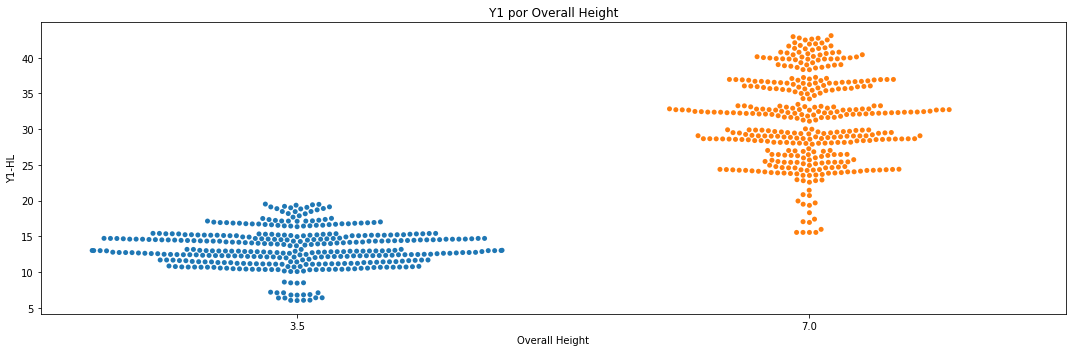

In [41]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Overall Height', y='Y1-HL', data=df).set_title('Y1 por Overall Height')
plt.tight_layout()
plt.show()


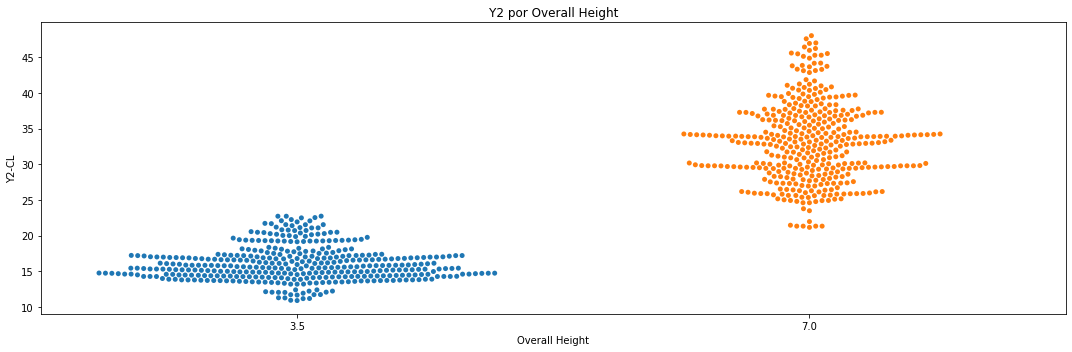

In [42]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Overall Height', y='Y2-CL', data=df).set_title('Y2 por Overall Height')
plt.tight_layout()
plt.show()

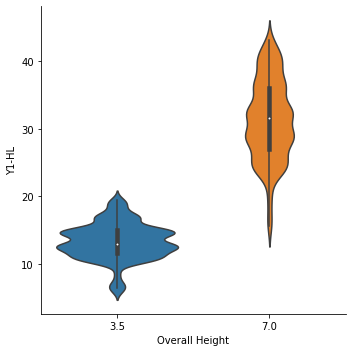

In [43]:
sns.catplot(x = 'Overall Height', y ='Y1-HL' , data = df, kind = "violin", bw = 0.25) # otra manera de ver lo mismo

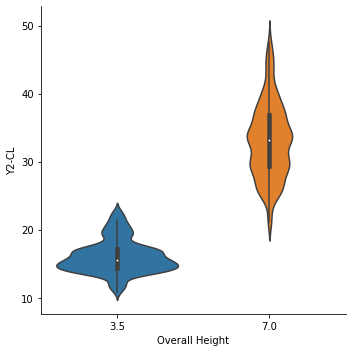

In [44]:
sns.catplot(x = 'Overall Height', y ='Y2-CL' , data = df, kind = "violin", bw = 0.25);

In [45]:
df['Orientation'].value_counts()

2    192
3    192
4    192
5    192
Name: Orientation, dtype: int64

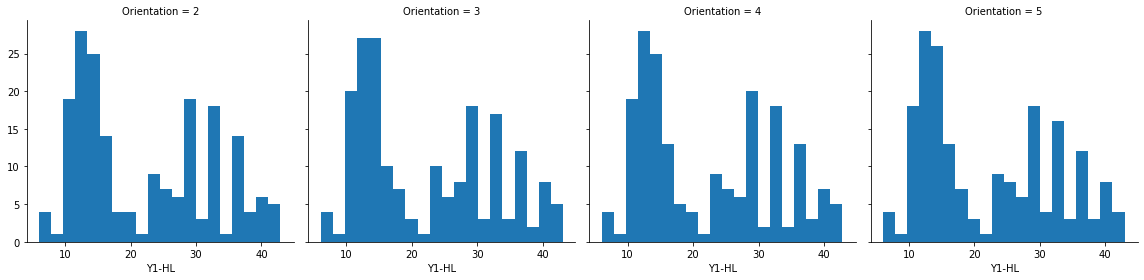

In [46]:
g = sns.FacetGrid(df, col='Orientation', height=4, sharey= True)
g.map(plt.hist, 'Y1-HL', bins=20)
# no hay demasiada significancia

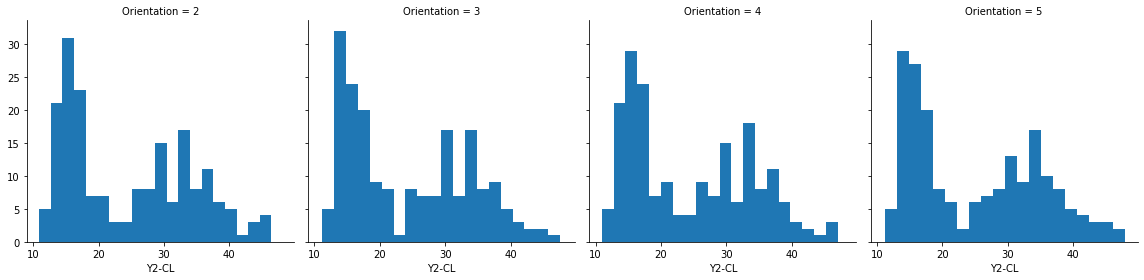

In [47]:
g = sns.FacetGrid(df, col='Orientation', height=4, sharey= True)
g.map(plt.hist, 'Y2-CL', bins=20)


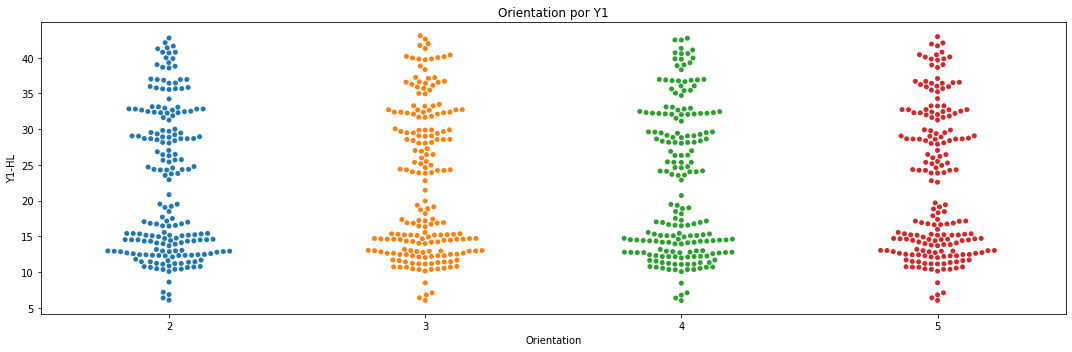

In [48]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Orientation', y='Y1-HL', data=df).set_title('Orientation por Y1')
plt.tight_layout()
plt.show()


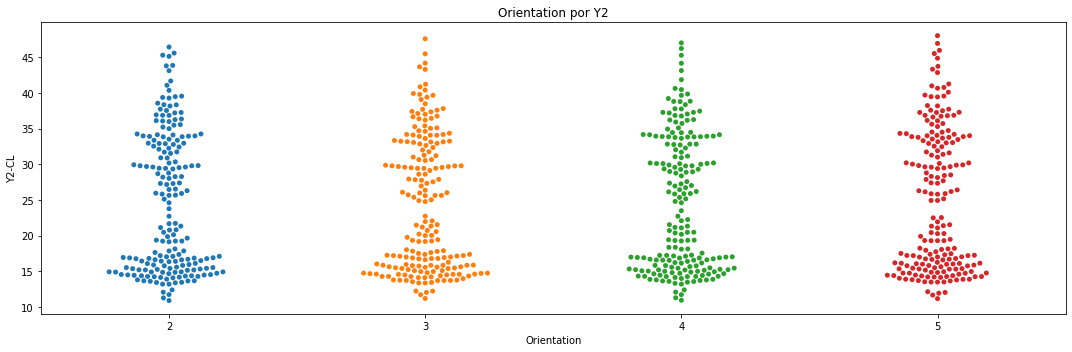

In [49]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Orientation', y='Y2-CL', data=df).set_title('Orientation por Y2')
plt.tight_layout()
plt.show()

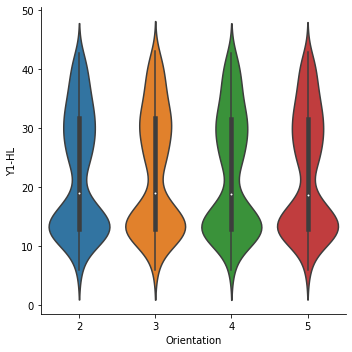

In [50]:
sns.catplot(x = 'Orientation', y ='Y1-HL' , data = df, kind = "violin", bw = 0.25);
#No hay variaciones considerables

In [51]:
df['Glazing Area'].value_counts()

0.10    240
0.25    240
0.40    240
0.00     48
Name: Glazing Area, dtype: int64

C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


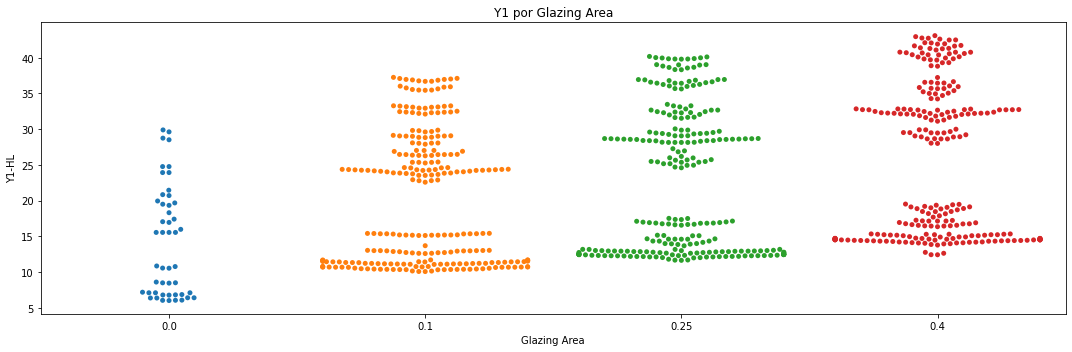

In [52]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Glazing Area', y='Y1-HL', data=df).set_title('Y1 por Glazing Area')
plt.tight_layout()
plt.show()


C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\juarezg\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


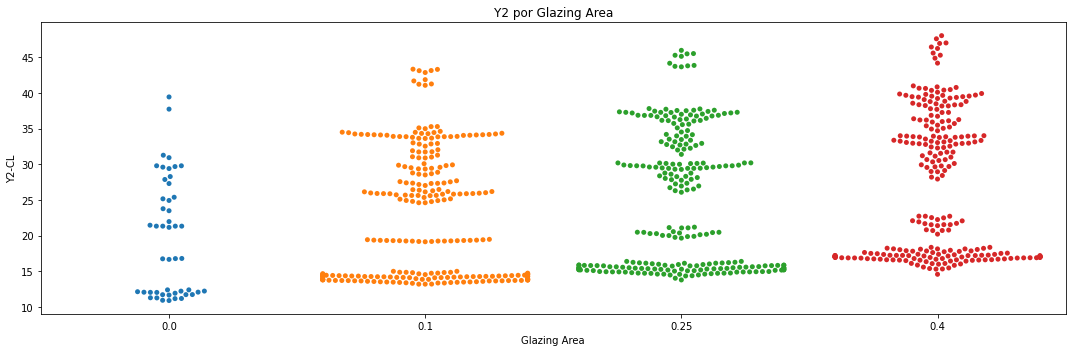

In [53]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Glazing Area', y='Y2-CL', data=df).set_title('Y2 por Glazing Area')
plt.tight_layout()
plt.show()

<AxesSubplot:>

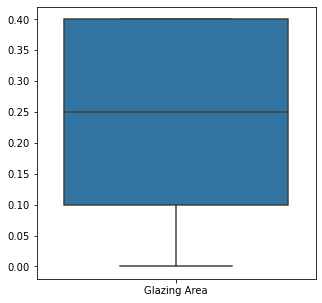

In [54]:
plt.figure(figsize = (5, 5))
sns.boxplot( data = df[['Glazing Area']])

In [55]:
df['Glazing Area Distribution'].value_counts()

1    144
2    144
3    144
4    144
5    144
0     48
Name: Glazing Area Distribution, dtype: int64

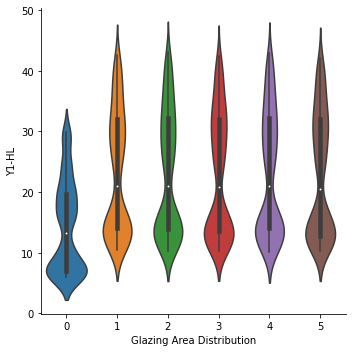

In [56]:

sns.catplot(x = 'Glazing Area Distribution', y ='Y1-HL' , data = df, kind = "violin", bw = 0.25);


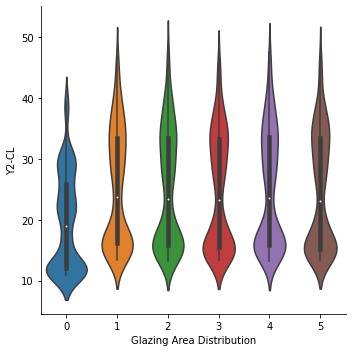

In [57]:
# relación entre variable numérica y categórica
#En el interior de la línea vemos un pequeño punto blanco que representa la mediana y, lógicamente, los límites de la línea más gruesa representan los cuartiles Q1 y Q3.

sns.catplot(x = 'Glazing Area Distribution', y ='Y2-CL' , data = df, kind = "violin", bw = 0.25);

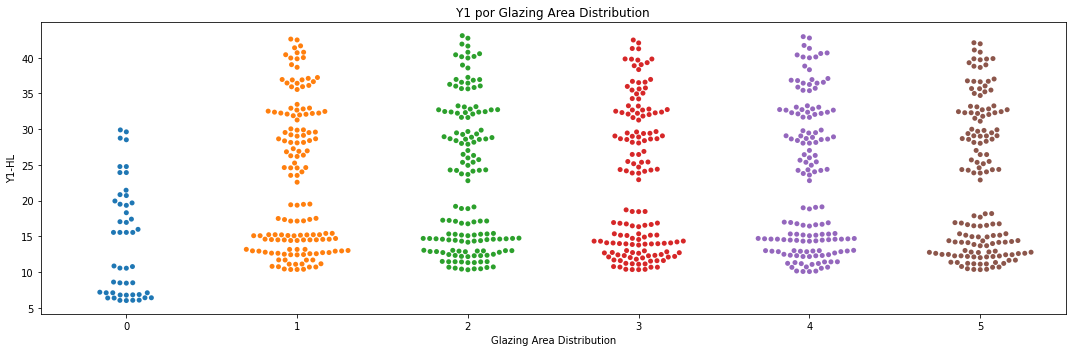

In [58]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Glazing Area Distribution', y='Y1-HL', data=df).set_title('Y1 por Glazing Area Distribution')
plt.tight_layout()
plt.show()


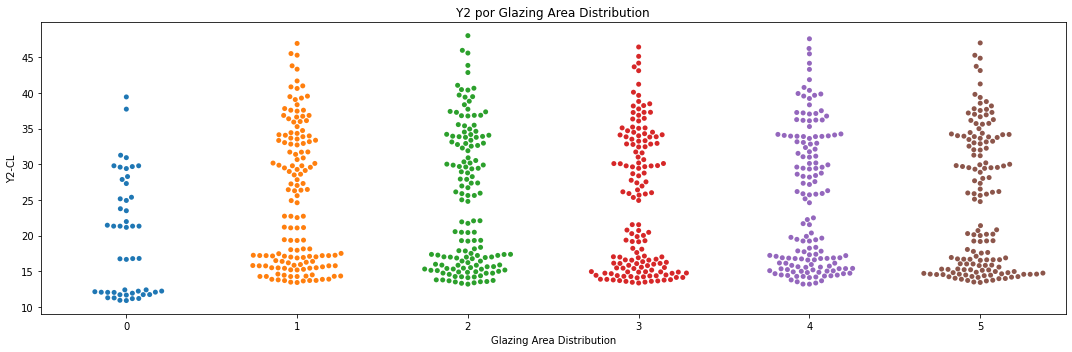

In [59]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='Glazing Area Distribution', y='Y2-CL', data=df).set_title('Y2 por Glazing Area Distribution')
plt.tight_layout()
plt.show()

# Graficos cruzados entre variables

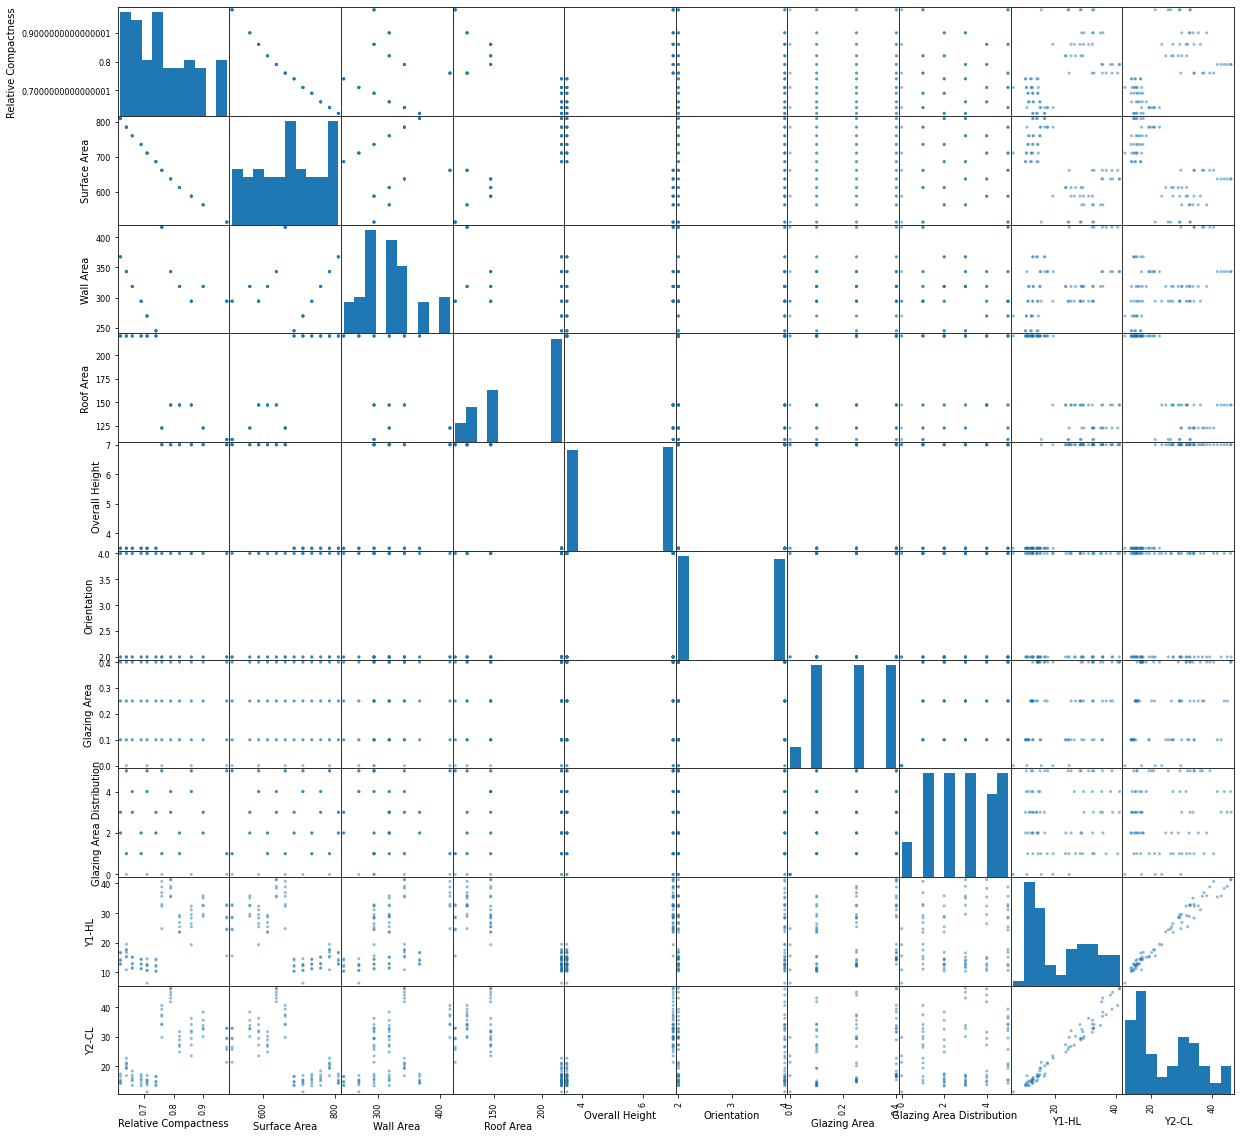

In [60]:
_=pd.plotting.scatter_matrix(df.iloc[::10], figsize=(20, 20), alpha=0.5)

# Matriz de correlación

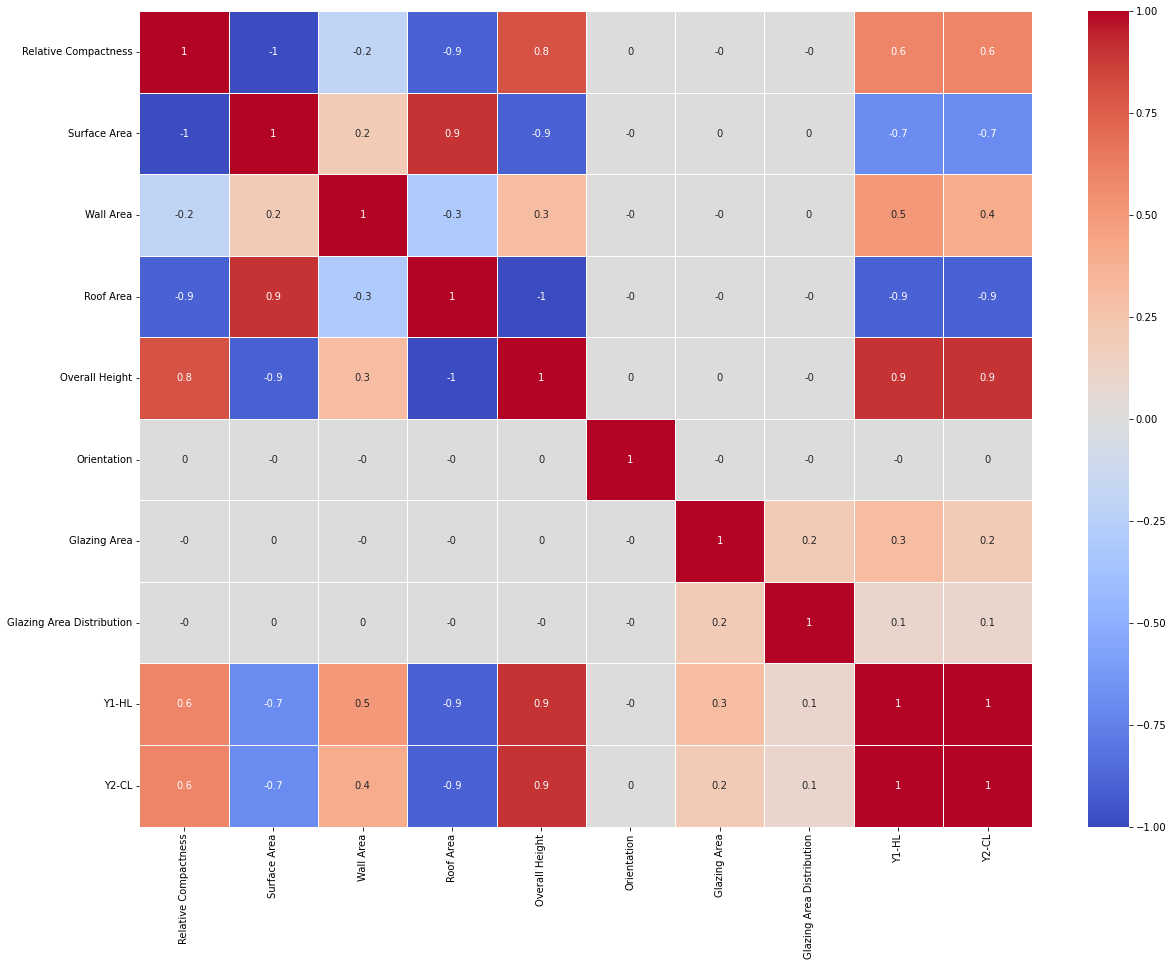

In [61]:
plt.figure(figsize=(20,15))
sns.heatmap(round(df.corr(),1), cmap="coolwarm", annot=True, linewidths=.5)

plt.show()

In [63]:
# Ordeno los valores de la correlación con target 1
df.corr()['Y1-HL'].sort_values()

Roof Area                   -0.861828
Surface Area                -0.658120
Orientation                 -0.002587
Glazing Area Distribution    0.087368
Glazing Area                 0.269842
Wall Area                    0.455671
Relative Compactness         0.622272
Overall Height               0.889430
Y2-CL                        0.975862
Y1-HL                        1.000000
Name: Y1-HL, dtype: float64

In [64]:
# Ordeno los valores de la correlación con target 2
df.corr()['Y2-CL'].sort_values()

Roof Area                   -0.862547
Surface Area                -0.672999
Orientation                  0.014290
Glazing Area Distribution    0.050525
Glazing Area                 0.207505
Wall Area                    0.427117
Relative Compactness         0.634339
Overall Height               0.895785
Y1-HL                        0.975862
Y2-CL                        1.000000
Name: Y2-CL, dtype: float64

# Definición del dataset de entrenamiento y el Test

In [65]:
X= df.drop(["Y1-HL","Y2-CL"], axis=1) # elimino las variables targets
y = df[["Y1-HL","Y2-CL"]].copy().reset_index(drop=True) # me quedo con las varaibles targets


In [67]:
# genero un pipiline para estandarizar los datos
pipeline_num= Pipeline([
        ('std_scaler', StandardScaler(with_mean=False))
    ])

In [68]:
#aplico el pipeline
X_scale = pipeline_num.fit_transform(X)
col_num= pipeline_num.get_feature_names_out(X.columns)
X_scale = pd.DataFrame(data=X_scale,columns=col_num)
X_scale

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
0,9.270770,5.844681,6.743418,2.442589,4.0,1.788854,0.000000,0.000000
1,9.270770,5.844681,6.743418,2.442589,4.0,2.683282,0.000000,0.000000
2,9.270770,5.844681,6.743418,2.442589,4.0,3.577709,0.000000,0.000000
3,9.270770,5.844681,6.743418,2.442589,4.0,4.472136,0.000000,0.000000
4,8.513972,6.401318,7.305369,2.713988,4.0,1.788854,0.000000,0.000000
...,...,...,...,...,...,...,...,...
763,6.054380,8.906181,7.867321,4.885178,2.0,4.472136,3.004496,3.225911
764,5.865181,9.184499,8.429272,4.885178,2.0,1.788854,3.004496,3.225911
765,5.865181,9.184499,8.429272,4.885178,2.0,2.683282,3.004496,3.225911
766,5.865181,9.184499,8.429272,4.885178,2.0,3.577709,3.004496,3.225911


### Separo en Train y Test

In [69]:
(X_train, X_test,
y_train, y_test) = train_test_split(X_scale,
                                    y,
                                   test_size=0.20,
                                    random_state=42)

**RN, FUNCIONA MEJOR SI SE ESCALAN LOS DATOS. RECORDAR NO SE ESCALA EL TARGET**

In [70]:
y_train

,Y1-HL,Y2-CL
60,23.53,27.31
618,18.90,22.09
346,29.27,29.90
294,32.84,32.71
231,11.43,14.83
...,...,...
71,32.21,33.67
106,26.33,27.36
270,10.67,14.26
435,28.62,30.12


## Definición de la arquitectura de la red neuronal
Para RN no es necesario la selección de caracteristicas

In [71]:

from keras import models
from keras import layers
import keras_metrics as km
import tensorflow as tf
from sklearn import metrics

**Función de activación** - se encarga de devolver una salida a partir de un valor de entrada

La función de activación debe ser no lineal.

Las funciones sigmoidal, tanh y ReLU son las más usadas convencionalmente en modelos Deep Learning.

El principal inconveniente de las funciones sigmoidal y tanh es la saturación de sus valores de salida. Esto dificulta el proceso de entrenamiento al no permitir la rápida minimización de la función de error usando el método del Gradiente Descendente

Por lo anterior se sugiere usar las funciones sigmoidal y tanh únicamente en las capas de salida, para tareas de clasificación binaria.

ReLU es la función de activación más usada en la actualidad, pues no tiene problemas de saturación y es más fácil de implementar que las funciones sigmoidal y tanh.

Se recomienda el uso de la función ReLU en las capas ocultas de la red implementada.

**Optimizador**: optimizar los valores de los parámetros para reducir el error cometido por la red. El proceso mediante el cual se hace esto se conoce como “backpropagation”

Stochastic Gradient Descent.

Adadelta.

Adagrad.

RMSprop.

Adam.

**Dropout**
es un metodo que desactiva un numero de neuronas de una red neuronal de forma aleatoria.

Este metodo ayuda a reducir el overfitting ya que las neuronas cercanas suelen aprender patrones que se relacionan 

Dropout tiene un parametro que indica la probabilidad de que las neuronas se queden activadas, este paremetro toma valores de 0 a 1, 0.5 suele usarse por defecto indicando que la mitad de las neuronas se quedaran activadas, si los valores son cercanos a 0 dropout desactivara menos neuronas, si es cercano a 1 desactivara muchas más neuronas.

**Loss - Funciones de perdida**:

Evalúa la desviación entre las predicciones realizadas por la red neuronal y los valores reales de las observaciones utilizadas durante el aprendizaje. Cuanto menor es el resultado de esta función, más eficiente es la red neuronal

In [72]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
#optimization_metrics=["mean_squared_error"] otra manera de insertar la métrica
#size_lyrs - cantidad de capas y cantidad de neuronas por capa

def crear_red_neuronal(size_lyrs=[8,16,32], act='relu', opt='Adam', dr=0.4, optimization_metrics=tf.keras.metrics.RootMeanSquaredError()):
  model = Sequential()
    
  # pongo la capa de entrada - la capa con 8 neuronas
  #input_dim las variables de entrada
  model.add(Dense(size_lyrs[0], input_dim=X_train.shape[1], activation=act))
 # DENSE --> capa
  # pongo la/s capa/s oculta/s (ojo la piojo, las capas ocultas no tienen porque ser todas iguales)
  for i in range(1,len(size_lyrs)):
    model.add(Dense(size_lyrs[i], activation=act))
  
  # add dropout, default is none
  model.add(Dropout(dr))
    
  # pongo la capa de salida
 # Adding Output Layer#If we make a regression with neural networks, we do not need to add an activation function compared to classification problems

  model.add(Dense(2))
 
  # compilo el modelo (le digo que ya terminé de armar la red y le configuro algunas cositas)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=optimization_metrics)
                    
  return model

In [73]:
model = crear_red_neuronal(act='relu')
print(model.summary())

# La primera capa tiene 72 parametros ya que tiene 8 neuronas X (8 variables + 1 bias) igual por cada capa.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
None


### Cada vez que todos nuestros datos pasan por la red neuronal decimos que se ha completado un Epoch

In [74]:
#  un epoch dentro de las redes neuronales equivale a una iteración del ciclo de entrenamiento completo en el conjunto de datos de entrenamiento.
# Cuando la metrica d ela validación empieza a bajar mientras la del entrenamiento empieza a subir se esta sobreajustando, se debería disminuir la epoch
#batch_size = Es el numero de datos que tiene cada iteración de un ciclo (epoch)
#validation_split= Este parámetro contendrá un número real entre 0 y 1 que determinará el porcentaje de los datos de entrenamiento a dedicar a validación. 
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)
# verbose permite obtener detalle de la salida, a mayor verbose mayor detalle
#OJO! SOLO EJECUTAR UNA VEZ SINO REENTRENA SOBRE LO YA ENTRENADO

Epoch 1/100
16/16 - 1s - loss: 671.9782 - root_mean_squared_error: 25.9225 - val_loss: 595.7523 - val_root_mean_squared_error: 24.4080 - 510ms/epoch - 32ms/step
Epoch 2/100
16/16 - 0s - loss: 620.5152 - root_mean_squared_error: 24.9101 - val_loss: 543.3130 - val_root_mean_squared_error: 23.3091 - 30ms/epoch - 2ms/step
Epoch 3/100
16/16 - 0s - loss: 556.8576 - root_mean_squared_error: 23.5978 - val_loss: 470.0347 - val_root_mean_squared_error: 21.6803 - 36ms/epoch - 2ms/step
Epoch 4/100
16/16 - 0s - loss: 478.8449 - root_mean_squared_error: 21.8825 - val_loss: 372.5012 - val_root_mean_squared_error: 19.3003 - 31ms/epoch - 2ms/step
Epoch 5/100
16/16 - 0s - loss: 369.7589 - root_mean_squared_error: 19.2291 - val_loss: 258.1837 - val_root_mean_squared_error: 16.0681 - 30ms/epoch - 2ms/step
Epoch 6/100
16/16 - 0s - loss: 265.8441 - root_mean_squared_error: 16.3047 - val_loss: 163.2501 - val_root_mean_squared_error: 12.7769 - 28ms/epoch - 2ms/step
Epoch 7/100
16/16 - 0s - loss: 195.8481 - ro

Epoch 54/100
16/16 - 0s - loss: 41.5620 - root_mean_squared_error: 6.4469 - val_loss: 11.6651 - val_root_mean_squared_error: 3.4154 - 34ms/epoch - 2ms/step
Epoch 55/100
16/16 - 0s - loss: 39.9502 - root_mean_squared_error: 6.3206 - val_loss: 13.0270 - val_root_mean_squared_error: 3.6093 - 32ms/epoch - 2ms/step
Epoch 56/100
16/16 - 0s - loss: 39.5878 - root_mean_squared_error: 6.2919 - val_loss: 12.6601 - val_root_mean_squared_error: 3.5581 - 34ms/epoch - 2ms/step
Epoch 57/100
16/16 - 0s - loss: 33.8307 - root_mean_squared_error: 5.8164 - val_loss: 11.8476 - val_root_mean_squared_error: 3.4420 - 34ms/epoch - 2ms/step
Epoch 58/100
16/16 - 0s - loss: 36.0056 - root_mean_squared_error: 6.0005 - val_loss: 11.6049 - val_root_mean_squared_error: 3.4066 - 36ms/epoch - 2ms/step
Epoch 59/100
16/16 - 0s - loss: 38.8180 - root_mean_squared_error: 6.2304 - val_loss: 13.3003 - val_root_mean_squared_error: 3.6470 - 34ms/epoch - 2ms/step
Epoch 60/100
16/16 - 0s - loss: 36.7963 - root_mean_squared_erro

**Predicción con Train**

In [75]:
y_pred_train = model.predict(X_train)
y_pred_train

array([[27.793564, 29.60293 ],
       [17.322895, 19.001247],
       [28.349144, 30.11756 ],
       ...,
       [11.004342, 12.530698],
       [26.742306, 28.379023],
       [27.665295, 29.413145]], dtype=float32)

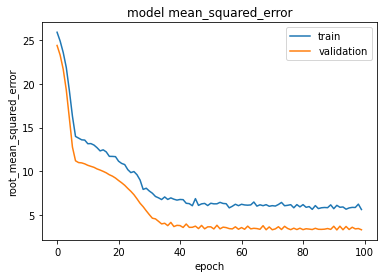

In [76]:
import matplotlib.pyplot as plt

plt.plot(training.history['root_mean_squared_error'])
plt.plot(training.history['val_root_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [77]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

MAE: 2.293372888316547
MSE: 10.462364480440069
RMSE: 3.234557849295645


**Predicción con Test**

In [78]:
y_pred_test = model.predict(X_test)
y_pred_test

array([[17.929718 , 19.635519 ],
       [13.674711 , 15.298669 ],
       [31.20507  , 33.01918  ],
       [33.513805 , 35.40648  ],
       [15.385018 , 17.059515 ],
       [28.55764  , 30.344404 ],
       [26.545647 , 28.253313 ],
       [29.485247 , 31.253744 ],
       [16.653627 , 18.315582 ],
       [29.18087  , 30.97124  ],
       [17.777325 , 19.46079  ],
       [34.300777 , 36.2284   ],
       [26.572092 , 28.25011  ],
       [ 9.836981 , 11.292001 ],
       [17.362759 , 18.99462  ],
       [36.334606 , 38.383556 ],
       [36.595753 , 38.645473 ],
       [12.013614 , 13.48925  ],
       [14.822379 , 16.387169 ],
       [34.591755 , 36.525303 ],
       [33.544613 , 35.464027 ],
       [34.340233 , 36.300224 ],
       [12.122471 , 13.793958 ],
       [29.363914 , 31.177034 ],
       [13.51128  , 15.200461 ],
       [29.671629 , 31.488417 ],
       [32.51041  , 34.37717  ],
       [31.278145 , 33.076546 ],
       [14.426351 , 16.113468 ],
       [16.618664 , 18.38296  ],
       [ 9

In [79]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

MAE: 2.4444467754611727
MSE: 11.718558653325395
RMSE: 3.423238036322539


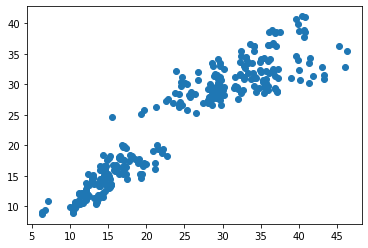

In [80]:
plt.scatter(y_test,y_pred_test)

### Utilización del GridSearch para encontrar los mejores parametros 

In [81]:
# crear el modelo inicial
from scikeras.wrappers import KerasRegressor # para regresión
model = KerasRegressor(model=crear_red_neuronal, epochs=50, batch_size=32, verbose=0, size_lyrs=[8], dr=0)

# definir el espacio de hiperparámetros
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(size_lyrs=layers, dr=drops)

# hacer la búsqueda
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, cv=5)
grid_result = grid.fit(X_train, y_train) # entrena el gridsearch

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .............dr=0.0, size_lyrs=[8];, score=0.221 total time=   0.6s
[CV 2/5] END .............dr=0.0, size_lyrs=[8];, score=0.474 total time=   0.6s
[CV 3/5] END .............dr=0.0, size_lyrs=[8];, score=0.328 total time=   0.6s
[CV 4/5] END .............dr=0.0, size_lyrs=[8];, score=0.003 total time=   0.6s
[CV 5/5] END ............dr=0.0, size_lyrs=[8];, score=-0.132 total time=   0.6s
[CV 1/5] END ............dr=0.0, size_lyrs=[10];, score=0.238 total time=   0.6s
[CV 2/5] END ............dr=0.0, size_lyrs=[10];, score=0.385 total time=   0.6s
[CV 3/5] END ............dr=0.0, size_lyrs=[10];, score=0.495 total time=   0.7s
[CV 4/5] END ............dr=0.0, size_lyrs=[10];, score=0.411 total time=   0.6s
[CV 5/5] END ............dr=0.0, size_lyrs=[10];, score=0.551 total time=   0.9s
[CV 1/5] END .........dr=0.0, size_lyrs=[10, 5];, score=0.682 total time=   0.7s
[CV 2/5] END ........dr=0.0, size_lyrs=[10, 5];

[CV 2/5] END .............dr=0.2, size_lyrs=[8];, score=0.211 total time=   1.1s
[CV 3/5] END .............dr=0.2, size_lyrs=[8];, score=0.512 total time=   1.2s
[CV 4/5] END ............dr=0.2, size_lyrs=[8];, score=-0.224 total time=   1.5s
[CV 5/5] END ............dr=0.2, size_lyrs=[8];, score=-0.685 total time=   1.3s
[CV 1/5] END ............dr=0.2, size_lyrs=[10];, score=0.348 total time=   1.6s
[CV 2/5] END ............dr=0.2, size_lyrs=[10];, score=0.181 total time=   1.3s
[CV 3/5] END ............dr=0.2, size_lyrs=[10];, score=0.431 total time=   1.2s
[CV 4/5] END ............dr=0.2, size_lyrs=[10];, score=0.244 total time=   1.1s
[CV 5/5] END ............dr=0.2, size_lyrs=[10];, score=0.281 total time=   1.1s
[CV 1/5] END .........dr=0.2, size_lyrs=[10, 5];, score=0.552 total time=   1.7s
[CV 2/5] END .........dr=0.2, size_lyrs=[10, 5];, score=0.577 total time=   1.9s
[CV 3/5] END .........dr=0.2, size_lyrs=[10, 5];, score=0.255 total time=   1.5s
[CV 4/5] END .........dr=0.2

In [82]:
grid_result.best_params_ # mejores parametros

{'dr': 0.0, 'size_lyrs': [12, 8, 4]}

### Entrenamiento

In [83]:
#Entrena el modelo on los mejores parametros
train_grid= grid_result.best_estimator_.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
16/16 - 1s - loss: 651.6954 - root_mean_squared_error: 17.2746 - val_loss: 580.9344 - val_root_mean_squared_error: 24.1026 - 599ms/epoch - 37ms/step
Epoch 2/50
16/16 - 0s - loss: 608.8533 - root_mean_squared_error: 24.6750 - val_loss: 544.8745 - val_root_mean_squared_error: 23.3425 - 45ms/epoch - 3ms/step
Epoch 3/50
16/16 - 0s - loss: 577.1577 - root_mean_squared_error: 24.0241 - val_loss: 518.1352 - val_root_mean_squared_error: 22.7626 - 43ms/epoch - 3ms/step
Epoch 4/50
16/16 - 0s - loss: 549.3793 - root_mean_squared_error: 23.4388 - val_loss: 488.9991 - val_root_mean_squared_error: 22.1133 - 44ms/epoch - 3ms/step
Epoch 5/50
16/16 - 0s - loss: 516.5046 - root_mean_squared_error: 22.7267 - val_loss: 453.5109 - val_root_mean_squared_error: 21.2958 - 46ms/epoch - 3ms/step
Epoch 6/50
16/16 - 0s - loss: 476.4027 - root_mean_squared_error: 21.8267 - val_loss: 409.8604 - val_root_mean_squared_error: 20.2450 - 45ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 427.7962 - root_mean

**Grafico de las métricas**

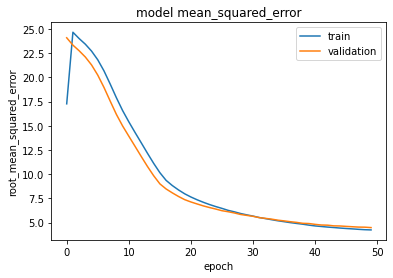

In [84]:
import matplotlib.pyplot as plt

plt.plot(train_grid.history_['root_mean_squared_error'])
plt.plot(train_grid.history_['val_root_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [85]:

y_pred_train = train_grid.predict(X_train)
y_pred_train

array([[28.1708  , 31.04074 ],
       [15.97202 , 16.60386 ],
       [29.465073, 31.90351 ],
       ...,
       [14.871709, 15.471338],
       [32.236515, 34.293343],
       [30.216202, 32.562454]], dtype=float32)

In [86]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

MAE: 3.2903066096166063
MSE: 18.20006829494151
RMSE: 4.266153805823404


### Testeo

In [87]:
y_pred_test = train_grid.predict(X_test)
y_pred_test

array([[15.98222  , 16.621206 ],
       [15.054796 , 15.787692 ],
       [32.083355 , 34.34526  ],
       [31.013401 , 34.123302 ],
       [14.713193 , 15.175975 ],
       [28.699839 , 31.59603  ],
       [30.61565  , 32.652752 ],
       [31.156006 , 33.32397  ],
       [16.231573 , 17.041616 ],
       [29.997025 , 32.47091  ],
       [15.879775 , 16.412556 ],
       [30.23586  , 33.65094  ],
       [30.657417 , 33.015934 ],
       [16.007647 , 16.92507  ],
       [16.659534 , 17.389812 ],
       [31.367107 , 34.920277 ],
       [31.561775 , 35.099865 ],
       [17.062687 , 18.229692 ],
       [17.775063 , 18.989977 ],
       [29.957405 , 33.26356  ],
       [30.417213 , 33.204456 ],
       [30.30732  , 33.40145  ],
       [13.14392  , 13.510165 ],
       [28.884243 , 32.133793 ],
       [13.602685 , 13.875798 ],
       [28.972763 , 32.21707  ],
       [31.958124 , 34.240818 ],
       [30.741173 , 33.483723 ],
       [14.655315 , 15.256992 ],
       [13.904038 , 14.09723  ],
       [15

In [88]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

MAE: 3.433458930870156
MSE: 19.12967960086889
RMSE: 4.373748918361557


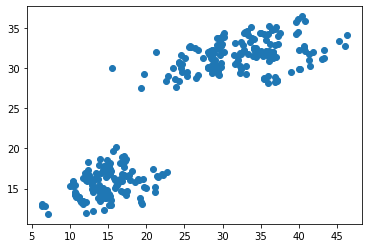

In [89]:
plt.scatter(y_test,y_pred_test)